<a href="https://colab.research.google.com/github/ahmaduk/Muhammad-Ahmad/blob/main/Image_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from skimage import io
from skimage.restoration import denoise_wavelet
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import math
from torch.serialization import default_restore_location
import argparse
import matplotlib.pyplot as plt
import cv2

In [ ]:
class DnCNN(nn.Module):
	
	def __init__(self, depth=20, n_channels=64, image_channels=1, bias=False, kernel_size=3):
		super(DnCNN, self).__init__()
		kernel_size = 3
		padding = 1

		self.bias = bias;
		if not bias:
			norm_layer = BFBatchNorm2d
		else:
			norm_layer = nn.BatchNorm2d
		self.depth = depth;


		self.first_layer = nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=self.bias)

		self.hidden_layer_list = [None] * (self.depth - 2);
		
		self.bn_layer_list = [None] * (self.depth -2 );
		
		for i in range(self.depth-2):
			self.hidden_layer_list[i] = nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=self.bias);
			self.bn_layer_list[i] = norm_layer(n_channels)
		
		self.hidden_layer_list = nn.ModuleList(self.hidden_layer_list);
		self.bn_layer_list = nn.ModuleList(self.bn_layer_list);
		self.last_layer = nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=self.bias)
		
		self._initialize_weights()

	@staticmethod
	def add_args(parser):
		"""Add model-specific arguments to the parser."""
		parser.add_argument("--in-channels", type=int, default=1, help="number of channels")
		parser.add_argument("--hidden-size", type=int, default=64, help="hidden dimension")
		parser.add_argument("--num-layers", default=20, type=int, help="number of layers")
		parser.add_argument("--bias", action='store_true', help="use residual bias")

	@classmethod
	def build_model(cls, args):
		return cls(image_channels = args.in_channels, n_channels = args.hidden_size, depth = args.num_layers, bias=args.bias)

	def forward(self, x):
		y = x
		out = self.first_layer(x);
		out = F.relu(out);

		for i in range(self.depth-2):
			out = self.hidden_layer_list[i](out);
			out = self.bn_layer_list[i](out);
			out = F.relu(out)

		out = self.last_layer(out);
		
		return y-out

	def _initialize_weights(self):
		for m in self.modules():
			if isinstance(m, nn.Conv2d):
				init.kaiming_normal_(m.weight, a=0, mode='fan_in')
				if m.bias is not None:
					init.constant_(m.bias, 0)
			elif isinstance(m, nn.BatchNorm2d) or isinstance(m, BFBatchNorm2d):
				m.weight.data.normal_(mean=0, std=math.sqrt(2./9./64.)).clamp_(-0.025,0.025)
				init.constant_(m.bias, 0)


class BFBatchNorm2d(nn.BatchNorm2d):
	def __init__(self, num_features, eps=1e-5, momentum=0.1, use_bias = False, affine=True):
		super(BFBatchNorm2d, self).__init__(num_features, eps, momentum)

		self.use_bias = use_bias;

	def forward(self, x):
		self._check_input_dim(x)
		y = x.transpose(0,1)
		return_shape = y.shape
		y = y.contiguous().view(x.size(1), -1)
		if self.use_bias:
			mu = y.mean(dim=1)
		sigma2 = y.var(dim=1)

		if self.training is not True:
			if self.use_bias:        
				y = y - self.running_mean.view(-1, 1)
			y = y / ( self.running_var.view(-1, 1)**0.5 + self.eps)
		else:
			if self.track_running_stats is True:
				with torch.no_grad():
					if self.use_bias:
						self.running_mean = (1-self.momentum)*self.running_mean + self.momentum * mu
					self.running_var = (1-self.momentum)*self.running_var + self.momentum * sigma2
			if self.use_bias:
				y = y - mu.view(-1,1)
			y = y / (sigma2.view(-1,1)**.5 + self.eps)

		if self.affine:
			y = self.weight.view(-1, 1) * y;
			if self.use_bias:
				y += self.bias.view(-1, 1)

		return y.view(return_shape).transpose(0,1)



USE_CUDA = True
device = torch.device('cuda') if (torch.cuda.is_available() and USE_CUDA) else torch.device('cpu')


def load_model(checkpoint_path):
    state_dict = torch.load(checkpoint_path, map_location=lambda s, l: default_restore_location(s, "cpu"))
    args = argparse.Namespace(**{ **vars(state_dict["args"]), "no_log": True})

    model = DnCNN.build_model(args).to(device)
    model.load_state_dict(state_dict["model"][0])
    model.eval()
    return model


def get_noise(data, noise_std = float(25)/255.0, mode='S', 
                    min_noise = float(5)/255., max_noise = float(55)/255.):
    noise = torch.randn_like(data);
    if mode == 'B':
        n = noise.shape[0];
        noise_tensor_array = (max_noise - min_noise) * torch.rand(n) + min_noise;
        for i in range(n):
            noise.data[i] = noise.data[i] * noise_tensor_array[i];
    else:
        noise.data = noise.data * noise_std;
    return noise

def denoise_image(im_path):
  """
  Return Original, Noisy Verion and Denoisy Version of Image
  """
  model = load_model('model.pt')
  im1 = io.imread(im_path).astype(float)/255

  im_tensor = torch.from_numpy(im1).unsqueeze(0).unsqueeze(0).to(device).float()
  noise = get_noise(im_tensor, noise_std = 10/255., mode='S')
  inp_test = im_tensor + noise
  noisy_test_im = inp_test.cpu().data.squeeze(0).squeeze(0).numpy()


  noise = get_noise(im_tensor, noise_std = 10/255., mode='S')
  inp_test = im_tensor + noise
  noisy_test_im = inp_test.cpu().data.squeeze(0).squeeze(0).numpy()

  res_im = model(inp_test)
  res_im = res_im.mul(255).clamp(0, 255)
  ii = res_im.cpu().data.squeeze(0).squeeze(0).numpy()

  return (im1, noisy_test_im, ii, im_tensor, res_im)


def ssim(clean, noisy, normalized=True):

    if normalized:
        clean = clean.mul(255).clamp(0, 255)
        noisy = noisy.mul(255).clamp(0, 255)

    clean = clean.cpu().detach().numpy().astype(np.float32)
    noisy = noisy.cpu().detach().numpy().astype(np.float32)
    return np.array([structural_similarity(c[0], n[0], data_range=255) for c, n in zip(clean, noisy)]).mean()

In [ ]:
def apply_median_filter(image_path):
  img = cv2.imread(image_path)
  median = cv2.medianBlur(img, 5)
  return median

def apply_mean_filter(image_path, filter_size=3):
  im = cv2.imread(image_path)
  mean_im = cv2.blur(im, (filter_size, filter_size))
  return mean_im

def apply_wavelet(image_path, method=1):
   im1 = io.imread(image_path)
   if method == 1:
      im = denoise_wavelet(im1, method='VisuShrink', mode='soft', rescale_sigma=True)
   elif method == 2:
     im = denoise_wavelet(im1, method='BayesShrink', mode='soft', rescale_sigma=True)
   return im

In [ ]:
def plot_image(img):
  plt.imshow(img, cmap=cm.gray)

## Testing 

In [ ]:
im_path = '/content/5.jpg'

In [ ]:
res = denoise_image(im_path)  # Prediction Line

### Original Image

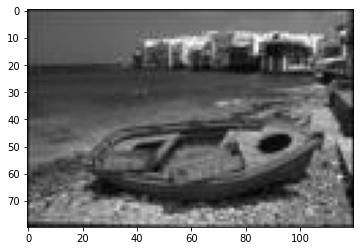

In [ ]:
plot_image(res[0])  # Original Version

### Noisy Version 

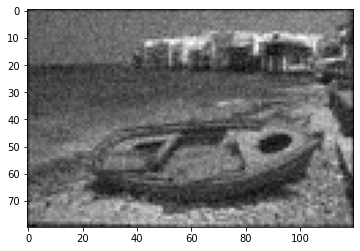

In [ ]:
plot_image(res[1])  # Noisy Version

### Denoisy Version

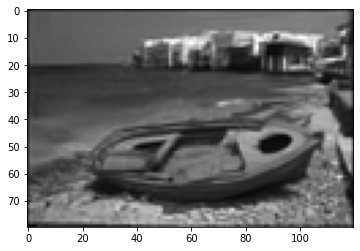

In [ ]:
plot_image(res[2])  # Denoisy Version

### Median Filter


In [ ]:
med_im = apply_median_filter(im_path)

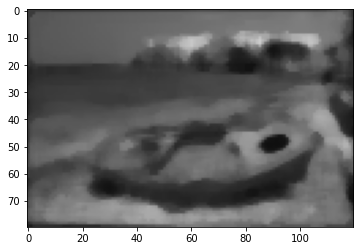

In [ ]:
plot_image(med_im)

### Mean Filter

In [ ]:
mean_im = apply_mean_filter(im_path, filter_size=3)

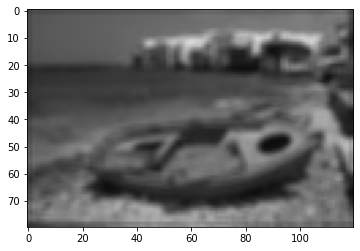

In [ ]:
plot_image(mean_im)

### Wavelet

In [ ]:
wav_im = apply_wavelet(im_path)

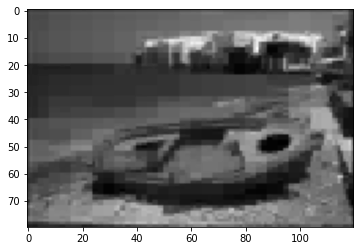

In [ ]:
plot_image(wav_im)

### SSIM

In [ ]:
ssim(res[3], res[4])

0.12699544597072215

In [ ]:
(score, diff) = structural_similarity(res[0], res[2], full=True)
diff = (diff * 255).astype("uint8")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  """Entry point for launching an IPython kernel.


In [ ]:
round(score, 4)

0.0001

In [ ]:
scores = []

In [ ]:
for i in range(1, 26):
  res = denoise_image(f'dataset/{i}.jpg')
  score = ssim(res[3], res[4])
  scores.append(round(score, 4))

In [ ]:
im_no = list(range(1,26))

In [ ]:
len(scores)

25

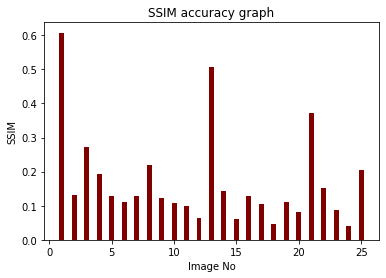

In [ ]:
plt.bar(im_no, scores, color ='maroon',width = 0.4)
 
plt.xlabel("Image No")
plt.ylabel("SSIM")
plt.title("SSIM accuracy graph")
plt.show()

### MAE

In [ ]:
mae_scores = []

In [ ]:
for i in range(1, 26):
  res = denoise_image(f'dataset/{i}.jpg')
  score = np.sqrt(((res[2]- res[0]) ** 2).mean())
  mae_scores.append(round(score, 4))

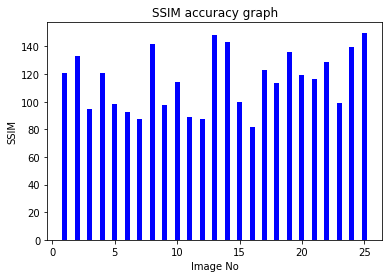

In [ ]:
plt.bar(im_no, mae_scores, color ='blue',width = 0.4)
 
plt.xlabel("Image No")
plt.ylabel("SSIM")
plt.title("SSIM accuracy graph")
plt.show()